# Data analysis and figures for PTSD project
* FYI: need to filter the mice bc right now the els data is also included in the big datafile -- DONE
* 8/21 refactoring according to the sleep repo, also creating figures for NCE to be submitted in Aug, 2023
* 1/22/24 cleanup GT
* 6/24/24 consolidated the many dataframes to one and added a plot which shows adult mice (13+ weeks)


## cloning the codebase from git:

In [2]:
!git clone https://github.com/GergelyTuri/sleep.git
%cd sleep
!pip install .

Cloning into 'sleep'...
remote: Enumerating objects: 1125, done.
remote: Counting objects: 100% (500/500), done.
remote: Compressing objects: 100% (304/304), done.
remote: Total 1125 (delta 312), reused 324 (delta 188), pack-reused 625
Receiving objects: 100% (1125/1125), 33.68 MiB | 20.68 MiB/s, done.
Resolving deltas: 100% (674/674), done.
/content/sleep
Processing /content/sleep
  Preparing metadata (setup.py) ... done
  Created wheel for sleep: filename=sleep-0.11-py3-none-any.whl size=1011 sha256=53f56c91db8827d85b3e4e6fa8bb1d03c200fdf78f82247b30286c944f8c0af9
  Stored in directory: /tmp/pip-ephem-wheel-cache-pr8h8tix/wheels/10/eb/42/5281370ac4a2d7b033087761ebaa8f968a9ef5108cbc009a46
Successfully built sleep


## importing some packages

In [63]:
from os.path import join
import sys
import glob

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
import seaborn as sns

from google.colab import data_table
data_table.enable_dataframe_formatter()

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['svg.fonttype'] = 'none'

from sleep.src.classes import core

sns.set_context('paper', font_scale=0.8)
import pandas as pd
from datetime import date
%matplotlib inline

### Input/output
* mounting google drive to read and write data.

In [73]:
dr = core.GoogleDrive()
gdrive  = dr.mount_drive()

# pls create a directory for yourself and change the `save_dir` to that
save_dir = '/gdrive/Shareddrives/Turi_lab/Data/PTSD_project/!analysis/saveFolder/R21_2024_PTSD'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### loading ALL data
This includes loading two spreadsheets, one of them is with mouse behavior (freezing) the other one contains some mouse age related info.

In [74]:
data = dr.load_spreadsheet_data('all_cohorts_freezing_FINAL')
data.replace('NA', np.NaN, inplace=True)
data[['freezing']] = data[['freezing']].apply(pd.to_numeric)
data[['date']] = data[['date']].apply(pd.to_datetime, format='mixed')
data = data[(data['els']=='n') &
            (data['psilocybin']=='n')]
data['cohort_id'] = data['cohort']+'_'+data['id']
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1245 entries, 1 to 1828
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   freezing           1240 non-null   float64       
 1   genotype           1245 non-null   object        
 2   id                 1245 non-null   object        
 3   day                1245 non-null   object        
 4   condition          1245 non-null   object        
 5   sex                1245 non-null   object        
 6   cohort             1245 non-null   object        
 7   exposure_mins      1240 non-null   object        
 8   analyzed_duration  1240 non-null   object        
 9   date               1176 non-null   datetime64[ns]
 10  time               1176 non-null   object        
 11  els                1245 non-null   object        
 12  psilocybin         1245 non-null   object        
 13  cohort_id          1245 non-null   object        
dtypes: datetime64

loading DOB-s

In [75]:
age_data = dr.load_spreadsheet_data('id_dob')
age_data['cohort_id']= age_data['cohort']+'_'+age_data['id']
age_data.drop(['id', 'cohort'], axis=1, inplace=True )
age_data['dob'] = pd.to_datetime(age_data['dob'], format='mixed')
age_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 1 to 214
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   dob        214 non-null    datetime64[ns]
 1   cohort_id  214 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 3.5+ KB


In [95]:
# merging freezing w/ DOBs
merged_df = data.merge(age_data,left_on='cohort_id',
                       right_on='cohort_id')
print(merged_df.info())
merged_df.head()

######################
# saving data to csv #
######################

# merged_df.to_csv(join(save_dir, f"all_cohorts_data_{date.today()}.csv"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   freezing           1120 non-null   float64       
 1   genotype           1125 non-null   object        
 2   id                 1125 non-null   object        
 3   day                1125 non-null   object        
 4   condition          1125 non-null   object        
 5   sex                1125 non-null   object        
 6   cohort             1125 non-null   object        
 7   exposure_mins      1120 non-null   object        
 8   analyzed_duration  1120 non-null   object        
 9   date               1056 non-null   datetime64[ns]
 10  time               1056 non-null   object        
 11  els                1125 non-null   object        
 12  psilocybin         1125 non-null   object        
 13  cohort_id          1125 non-null   object        
 14  dob     

In [80]:
print('all mice: {}\n'.format(merged_df['cohort_id'].nunique()))
print(merged_df.groupby('sex')['cohort_id'].nunique())

all mice: 149

sex
female    56
male      93
Name: cohort_id, dtype: int64


Calculating the mice's ages (in weeks) when the protocol started

In [84]:
# filtering out the sefla day from the data
df_sefla = merged_df[merged_df["day"] == "sefla"]

# calculating the age in weeks
df_sefla['age_at_SEFLA'] = ((df_sefla.loc[:,('date')] - df_sefla.loc[:,('dob')]).dt.days/7).round(1)
df_sefla.reset_index(inplace=True, drop=True)
df_sefla.info()
# this will result in only one row per mouse

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   freezing           149 non-null    float64       
 1   genotype           149 non-null    object        
 2   id                 149 non-null    object        
 3   day                149 non-null    object        
 4   condition          149 non-null    object        
 5   sex                149 non-null    object        
 6   cohort             149 non-null    object        
 7   exposure_mins      149 non-null    object        
 8   analyzed_duration  149 non-null    object        
 9   date               149 non-null    datetime64[ns]
 10  time               149 non-null    object        
 11  els                149 non-null    object        
 12  psilocybin         149 non-null    object        
 13  cohort_id          149 non-null    object        
 14  dob       

<ipython-input-84-cf4ebeccf532>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sefla['age_at_SEFLA'] = ((df_sefla.loc[:,('date')] - df_sefla.loc[:,('dob')]).dt.days/7).round(1)


In [85]:
df_sefla_age = df_sefla[['cohort_id', 'age_at_SEFLA']]

# saving for later use
# df_age.to_csv(join(save_dir, f'age_at_sefla_{date.today()}.csv'))

### Merging age table with behavior table

In [96]:
result = pd.merge(merged_df, df_sefla_age, on='cohort_id', how='left')
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   freezing           1120 non-null   float64       
 1   genotype           1125 non-null   object        
 2   id                 1125 non-null   object        
 3   day                1125 non-null   object        
 4   condition          1125 non-null   object        
 5   sex                1125 non-null   object        
 6   cohort             1125 non-null   object        
 7   exposure_mins      1120 non-null   object        
 8   analyzed_duration  1120 non-null   object        
 9   date               1056 non-null   datetime64[ns]
 10  time               1056 non-null   object        
 11  els                1125 non-null   object        
 12  psilocybin         1125 non-null   object        
 13  cohort_id          1125 non-null   object        
 14  dob     

In [87]:
# result = merged_df.join(df_sefla_age, how='outer')
# result

## Plotting age distribution

Text(0.5, 1.0, 'Males and Females (N=149)')

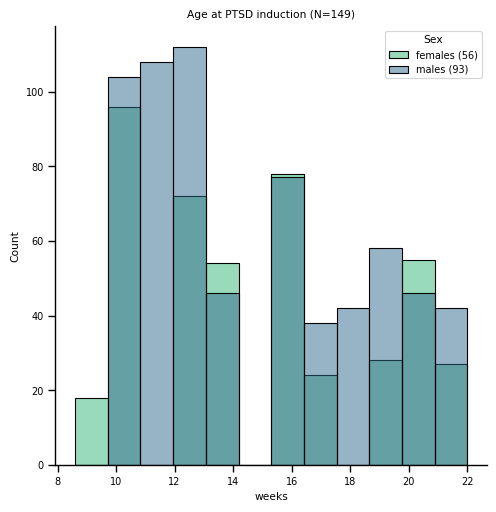

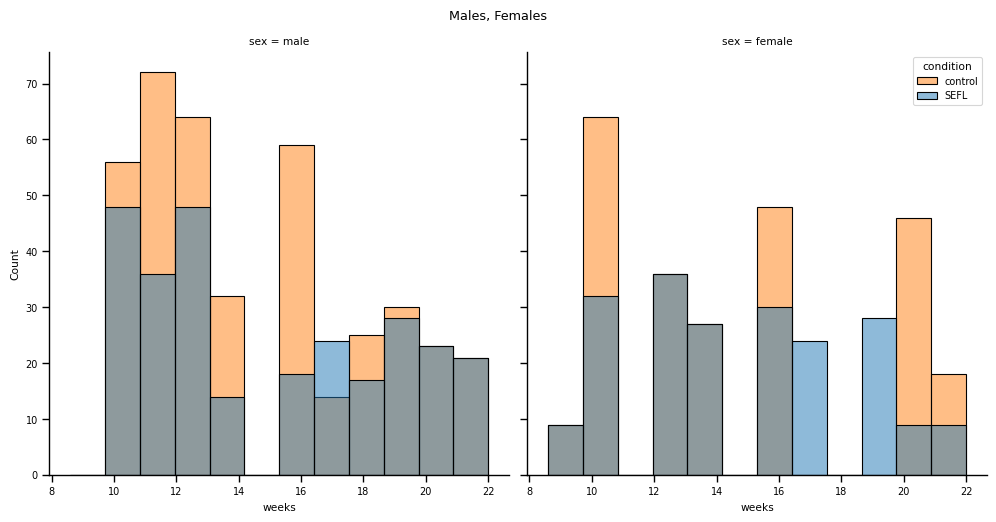

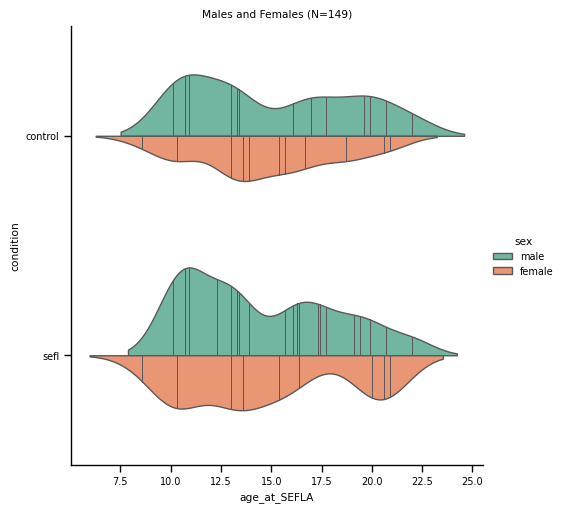

In [98]:
df = result
# plot1
num_sexes = df.groupby(['sex'])['cohort_id'].nunique()
num_mice = df.cohort_id.nunique()

d = sns.displot(df, x='age_at_SEFLA', hue='sex', palette="viridis",
                legend=False)
plt.title('Age at PTSD induction (N=%s)' %num_mice,) #fontsize=18
d.set_xlabels('weeks') #fontsize=20
# d.set_ylabels(fontsize=20)
plt.legend(title='Sex', loc='upper right', labels=['females (%s)' % num_sexes[0],
                                                   'males (%s)' % num_sexes[1]])

# plot2
d2 = sns.displot(df, x="age_at_SEFLA", col="sex", hue="condition",
                 legend=False)
d2.set_xlabels('weeks') #fontsize=20
d2.fig.suptitle("Males, Females", y=1.03) #, fontsize=20
plt.legend(title='condition', loc='upper right', labels=['control','SEFL'])

# plot3
d3 = sns.catplot(data=df, y='condition', x="age_at_SEFLA", legend=True,
                 orient='h', hue='sex', kind='violin', inner='stick',
                 split=True, palette='Set2',
                 density_norm='count', common_norm=True)
plt.title(f'Males and Females (N={df.cohort_id.nunique()})',
          ) #fontsize=20

# plt.savefig(join(save_dir, 'noELS', f'sex_distrib_violin_{date.today()}.png'),
#             transparent=True, dpi=300, figsize=(5,5), bbox_inches='tight')
# d.savefig(join(save_dir, 'noELS',f'SEFL_age_at_PTSD_all_{date.today()}.png'),
#           transparent=True, dpi=300, figsize=(5,5), bbox_inches='tight')
# d2.savefig(join(save_dir, 'noELS',f'SEFL_age_at_PTSD_sexes_{date.today()}.png'),
#            transparent=True, dpi=300, figsize=(5,10), bbox_inches='tight')


# TODO: controlling the titles of the hue'ed plots

In [99]:
# cohorts included
print(f'cohorts: {result.cohort.unique()}\n')
print(f'number of mice: {result.cohort_id.nunique()}\n')
print(result.groupby(['sex'])['cohort_id'].nunique())

cohorts: ['ptsd1' 'ptsd2' 'ptsd3' 'ptsd4' 'ptsd5' 'ptsd6' 'ptsd7' 'ptsd8' 'ptsd9'
 'ptsd10' 'els1' 'els2' 'ptsd12' 'ptsd14']

number of mice: 149

sex
female    56
male      93
Name: cohort_id, dtype: int64


### Plotting behavior (freezing) results
* one plot is one cohort
* blue is control, orange is stress group

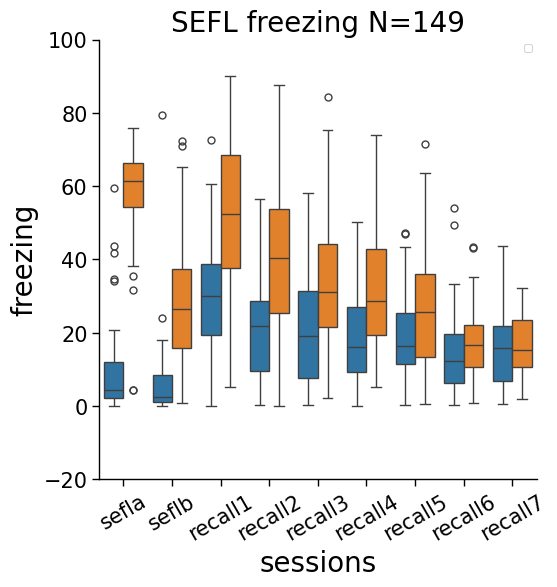

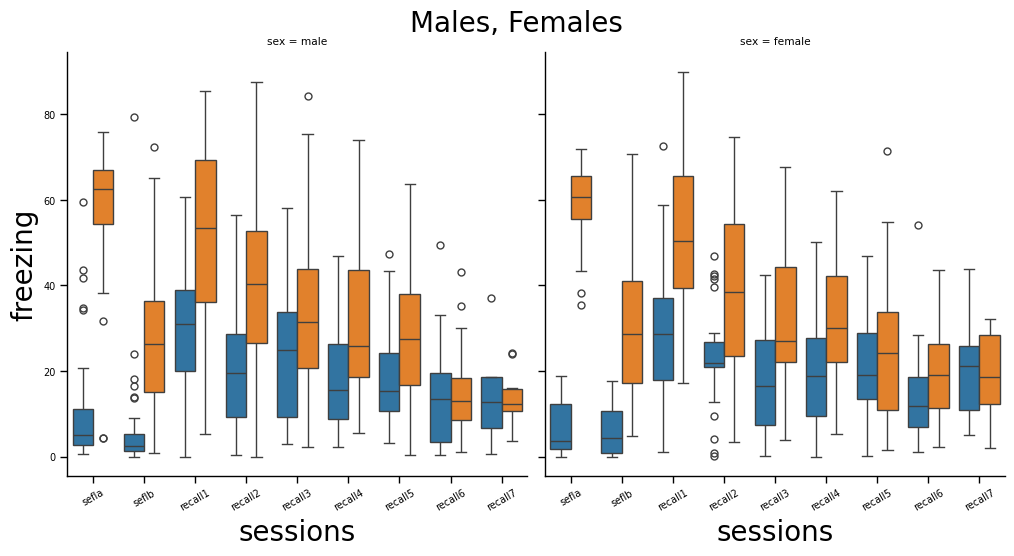

In [100]:
# plot1
df = result

g = sns.catplot(data = df, kind='box',
                x="day", y="freezing", hue="condition", legend=False)

plt.title(f'SEFL freezing N={df.cohort_id.nunique()}',
          fontsize=20)
plt.legend(loc='upper right')
g.set_xticklabels(rotation=30, fontsize=15)
g.set_xlabels('sessions', fontsize=20)
g.set_ylabels(fontsize=20)
g.set_yticklabels(fontsize=15)

# plot2
g2 = sns.catplot(data= df, kind='box',
                x='day', y='freezing', hue='condition',
                 col='sex', legend=False)
g2.set_xticklabels(rotation = 30)
g2.set_ylabels(fontsize=20)
g2.fig.suptitle("Males, Females", y=1.03, fontsize=20)
g2.set_xlabels('sessions', fontsize=20)

# g.savefig(join(save_dir, f'SEFL_freezing_at_PTSD_all_boxplot_{date.today()}.png'),
#           transparent=True, dpi=300)
# g2.savefig(join(save_dir, f'SEFL_freezing_at_PTSD_sexes_boxplot_{date.today()}.png'),
#            transparent=True, dpi=300)

### Plotting cohorts separately

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


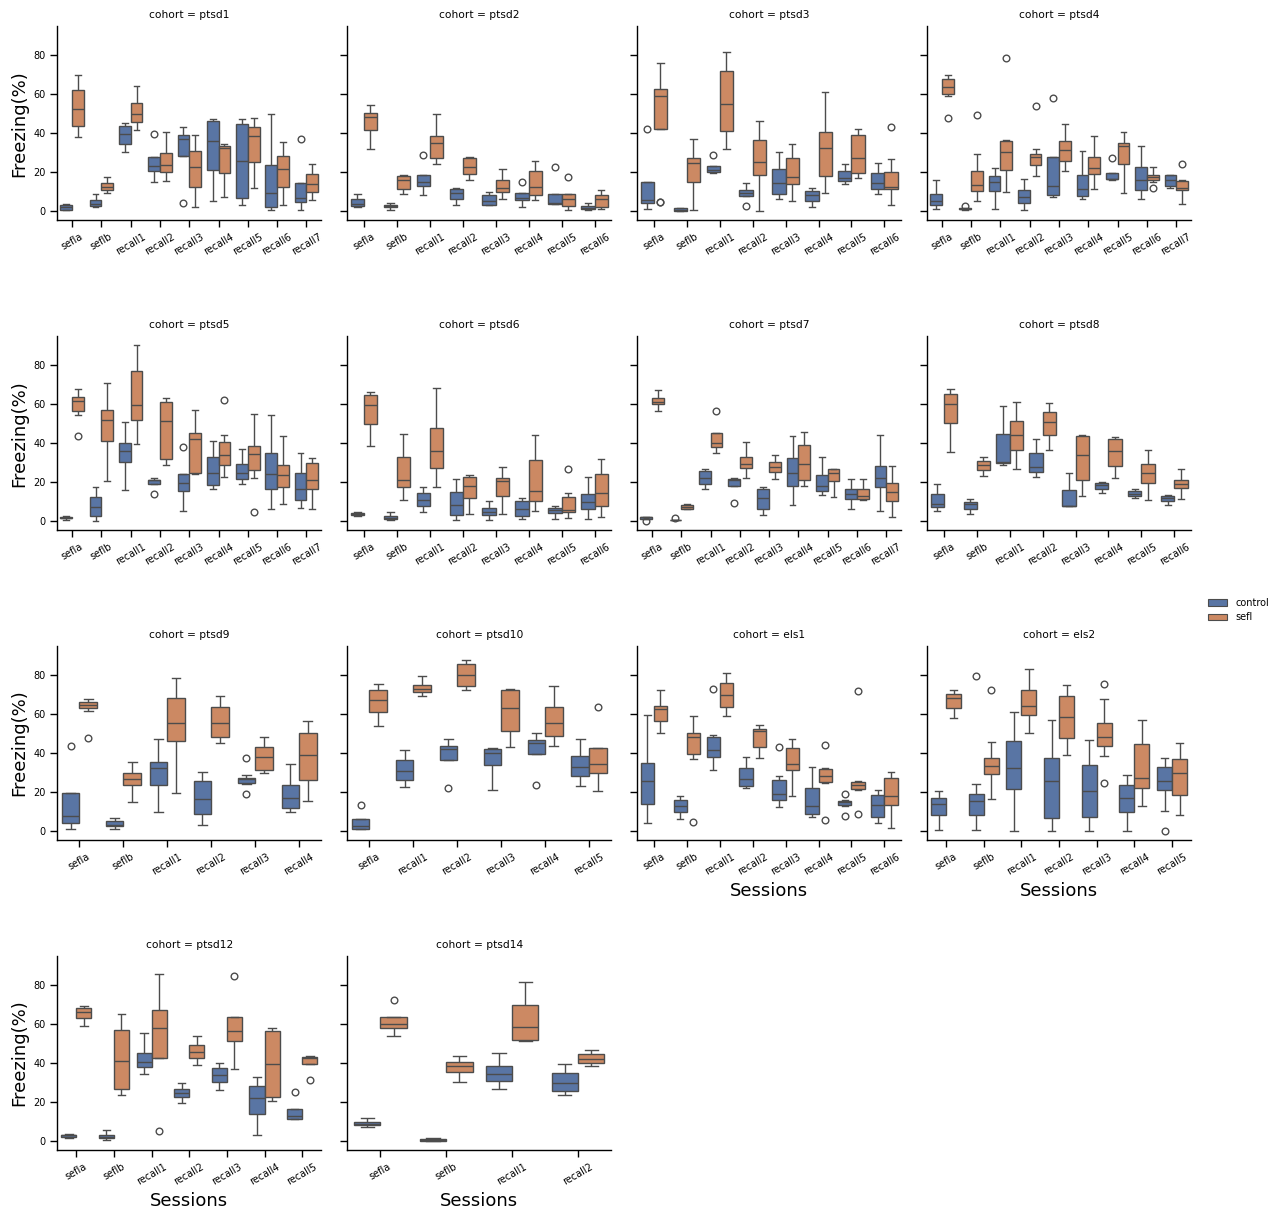

In [103]:
df = result
g = sns.FacetGrid(df, col="cohort", col_wrap=4,
                  sharey=True, sharex=False
                  )
g.map(sns.boxplot, "day", "freezing", "condition",
      hue_order=["control", "sefl"], palette="deep"
      )
g.set_xticklabels(rotation = 30)
g.add_legend()
g.figure.subplots_adjust(hspace=.35)
g.set_axis_labels("Sessions", "Freezing(%)")
g.set_xlabels(fontsize=13)
g.set_ylabels(fontsize=13)
g.fig.subplots_adjust(hspace=0.6, wspace=.1)
# g.savefig(join(save_dir, 'noELS',
#                f'ALL_cohorts_ SEFL_frezing_per_cohort_boxplot_grid{date.today()}.png'),
#           transparent=True, dpi=300, bbox_inches='tight')

Filtering out some cohorts

In [104]:
# These are the cohorts which are not going to be included
# in the rest of the analyses:
# ptsd1, ptsd7 -> sleep
# ptsd8, ptsd10, ptsd12 -> sert hets
# ptsd11 -> pattern sep
# FYI ptsd9 has data only up to recall4
# ptsd13 -> psilocybin administration after seflb
# els1, els2 -> els mice

cohort_list = ['ptsd2','ptsd3', 'ptsd4', 'ptsd5', 'ptsd6', 'ptsd9']
day_list = ['sefla','seflb','recall1', 'recall2', 'recall3',
            'recall4', 'recall5']
filtered_freezing = result[(result['cohort'].isin(cohort_list)) &
                              (result['day'].isin(day_list))]

# exporting data to CSV
# filtered_freezing.to_csv(join(save_dir, f'filtered_nonELS_mice_{date.today()}.csv'))

In [105]:
filtered_freezing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 72 to 780
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   freezing           500 non-null    float64       
 1   genotype           500 non-null    object        
 2   id                 500 non-null    object        
 3   day                500 non-null    object        
 4   condition          500 non-null    object        
 5   sex                500 non-null    object        
 6   cohort             500 non-null    object        
 7   exposure_mins      500 non-null    object        
 8   analyzed_duration  500 non-null    object        
 9   date               500 non-null    datetime64[ns]
 10  time               500 non-null    object        
 11  els                500 non-null    object        
 12  psilocybin         500 non-null    object        
 13  cohort_id          500 non-null    object        
 14  dob           

### Plotting behavior average accross cohorts and sexes

#### All mice

<Figure size 1920x1440 with 0 Axes>

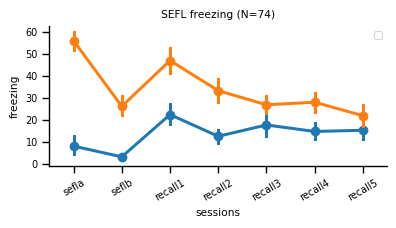

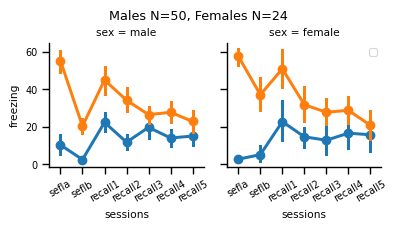

<Figure size 1920x1440 with 0 Axes>

In [106]:
# df plot1

df = filtered_freezing

g = sns.catplot(data = df, kind='point',
               x="day", y="freezing", hue="condition", legend=False,
              height=2, aspect=2)
plt.title(f'SEFL freezing (N={df.cohort_id.nunique()})',
          )#fontsize=20
plt.legend(loc='upper right')
g.set_xticklabels(rotation=30)#, fontsize=15
g.set_xlabels('sessions', )#fontsize=20
g.set_ylabels()#fontsize=20
# g.set_yticklabels(fontsize=15)

# df plot2
num_sexes = df.groupby(['sex'])['cohort_id'].nunique()

g2 = sns.catplot(data= df, kind='point',
                x='day', y='freezing', hue='condition',
                 col='sex', legend=False, height=2)

plt.legend(loc='upper right')
g2.set_xticklabels(rotation = 30)#, fontsize=15
g2.set_xlabels('sessions', )#fontsize=20
g2.set_ylabels()#fontsize=20
# g.set_yticklabels(fontsize=15)

title = f'Males N={num_sexes[1]}, Females N={num_sexes[0]}'
g2.fig.suptitle(title, y=1.03, )#fontsize=20
plt.figure(dpi=300)

# saving
# g.savefig(join(save_dir,
#                f'SEFL_frezing_selected_cohorts_{date.today()}.svg'),
#           transparent=True, dpi=300, bbox_inches='tight', format='svg')
# g2.savefig(join(save_dir,
#                 f'SEFL_frezing_selected_cohorts_males_females_{date.today()}.svg'),
#            transparent=True, dpi=300, bbox_inches='tight', format='svg')

#### Only adult mice (13 weeks or older)

In [116]:
# These are the cohorts which are not going to be included
# in the rest of the analyses:
# ptsd1, ptsd7 -> sleep
# ptsd8, ptsd10, ptsd12 -> sert hets
# ptsd11 -> pattern sep
# FYI ptsd9 has data only up to recall4
# ptsd13 -> psilocybin administration after seflb
# els1, els2 -> els mice
df = result

cohort_list = ['ptsd2','ptsd3', 'ptsd4', 'ptsd5', 'ptsd6', 'ptsd9']
day_list = ['sefla','seflb','recall1', 'recall2', 'recall3',
            'recall4', 'recall5']
adult_filtered_freezing = df[(df['cohort'].isin(cohort_list)) &
                              (df['day'].isin(day_list)) &
                       (df['age_at_SEFLA'] >= 13)]

# exporting data to CSV
adult_filtered_freezing.to_csv(join(save_dir, f'filtered_adult_nonELS_mice_{date.today()}.csv'))

In [108]:
adult_filtered_freezing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 213 entries, 152 to 780
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   freezing           213 non-null    float64       
 1   genotype           213 non-null    object        
 2   id                 213 non-null    object        
 3   day                213 non-null    object        
 4   condition          213 non-null    object        
 5   sex                213 non-null    object        
 6   cohort             213 non-null    object        
 7   exposure_mins      213 non-null    object        
 8   analyzed_duration  213 non-null    object        
 9   date               213 non-null    datetime64[ns]
 10  time               213 non-null    object        
 11  els                213 non-null    object        
 12  psilocybin         213 non-null    object        
 13  cohort_id          213 non-null    object        
 14  dob          

In [115]:
adult_filtered_freezing['cohort_id'].nunique()

33

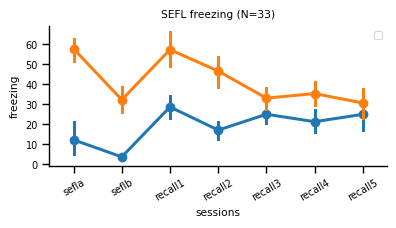

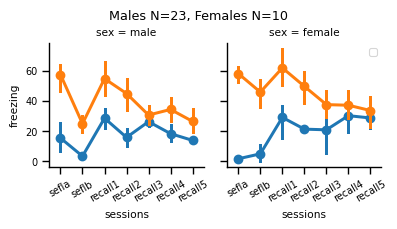

<Figure size 1920x1440 with 0 Axes>

In [113]:
# df plot1

df = adult_filtered_freezing

g = sns.catplot(data = df, kind='point',
               x="day", y="freezing", hue="condition", legend=False,
              height=2, aspect=2)
plt.title(f'SEFL freezing (N={df.cohort_id.nunique()})',
          )#fontsize=20
plt.legend(loc='upper right')
g.set_xticklabels(rotation=30)#, fontsize=15
g.set_xlabels('sessions', )#fontsize=20
g.set_ylabels()#fontsize=20
# g.set_yticklabels(fontsize=15)

# df plot2
num_sexes = df.groupby(['sex'])['cohort_id'].nunique()

g2 = sns.catplot(data= df, kind='point',
                x='day', y='freezing', hue='condition',
                 col='sex', legend=False, height=2)

plt.legend(loc='upper right')
g2.set_xticklabels(rotation = 30)#, fontsize=15
g2.set_xlabels('sessions', )#fontsize=20
g2.set_ylabels()#fontsize=20
# g.set_yticklabels(fontsize=15)

title = f'Males N={num_sexes[1]}, Females N={num_sexes[0]}'
g2.fig.suptitle(title, y=1.03, )#fontsize=20
plt.figure(dpi=300)

# saving
g.savefig(join(save_dir,
               f'Adult_SEFL_frezing_selected_cohorts_{date.today()}.svg'),
          transparent=True, dpi=300, bbox_inches='tight', format='svg')
g2.savefig(join(save_dir,
                f'Adult_SEFL_frezing_selected_cohorts_males_females_{date.today()}.svg'),
           transparent=True, dpi=300, bbox_inches='tight', format='svg')

### Plotting behavior in the stress group (SEFL) males vs. females
* female freezing seems to be higher at SEFLb. but is it significant?

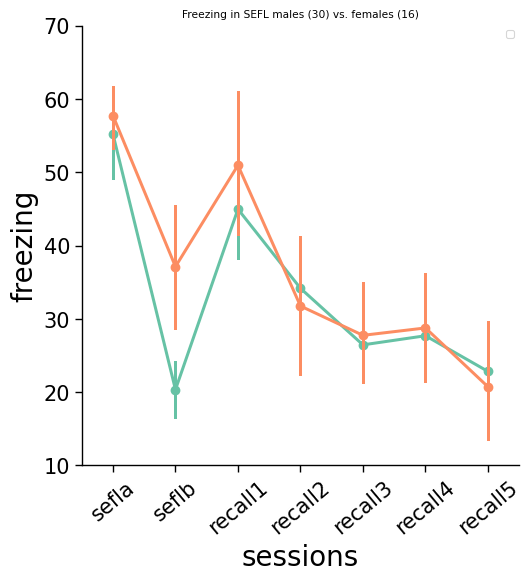

In [110]:
sefl_sexes = filtered_freezing[filtered_freezing['condition'] == 'sefl']

s_females = sefl_sexes.groupby('sex')['cohort_id'].nunique()[0]
s_males = sefl_sexes.groupby('sex')['cohort_id'].nunique()[1]

g = sns.catplot(data = sefl_sexes, kind='point',
               x="day", y="freezing", hue="sex", legend=False,
               palette='Set2')
plt.title(f'Freezing in SEFL males ({s_males}) vs. females ({s_females})')
plt.legend(loc='upper right')
g.set_xticklabels(rotation=40, fontsize=15)
g.set_xlabels('sessions', fontsize=20)
g.set_ylabels(fontsize=20)
g.set_yticklabels(fontsize=15)

# g.savefig(join(save_dir, 'noELS',
#                        f'Freezing_SEFL_males_vs_females_pointplot{date.today()}.png'),
#           transparent=True, dpi=300, bbox_inches='tight')

### Plotting behavior in the control group, males vs. females.
* not much difference

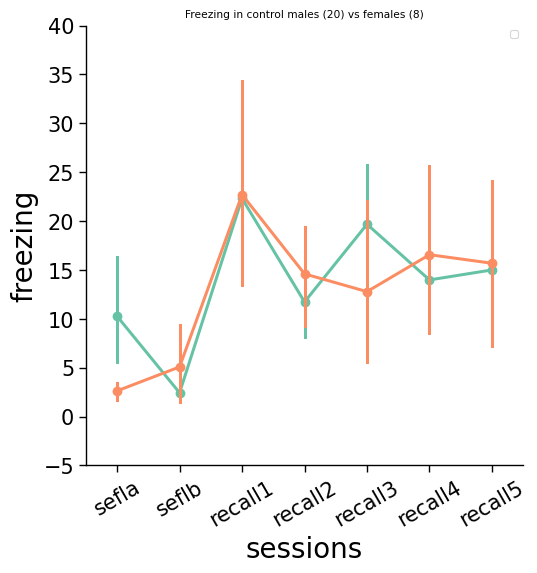

In [111]:
ctrl_sexes = filtered_freezing[filtered_freezing['condition'] == 'control']

c_females = ctrl_sexes.groupby('sex')['cohort_id'].nunique()[0]
c_males = ctrl_sexes.groupby('sex')['cohort_id'].nunique()[1]

g = sns.catplot(data = ctrl_sexes, kind='point',
               x="day", y="freezing", hue="sex", legend=False,
               palette='Set2')
plt.title(f'Freezing in control males ({c_males}) vs females ({c_females})')
plt.legend(loc='upper right')
g.set_xticklabels(rotation=30, fontsize=15)
g.set_xlabels('sessions', fontsize=20)
g.set_ylabels(fontsize=20)
g.set_yticklabels(fontsize=15)

# g.savefig(join(save_dir, 'noELS',
#                        f'Freezing_CONTROL_males_vs_females_pointplot_{date.today()}.png'),
#           transparent=True, dpi=300, bbox_inches='tight')

### Plotting mean behavior responses and individual mice
* high variance in the group
* Can the freezing level at recall5 predicted based on previous behavior?



([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'sefla'),
  Text(1, 0, 'seflb'),
  Text(2, 0, 'recall1'),
  Text(3, 0, 'recall2'),
  Text(4, 0, 'recall3'),
  Text(5, 0, 'recall4'),
  Text(6, 0, 'recall5')])

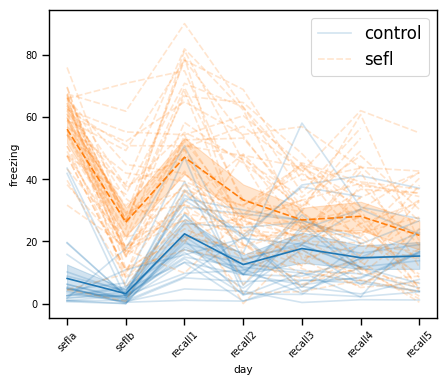

In [112]:
f, ax = plt.subplots(figsize=(5,4))
g = sns.lineplot(data=filtered_freezing, x='day', y='freezing', hue='condition',
                 units='cohort_id', estimator=None, style='condition', alpha=.2,
                 ax=ax)
g = sns.lineplot(data=filtered_freezing, x='day', y='freezing', hue='condition',
                 style='condition', legend=False, ax=ax)
plt.legend(fontsize=12)
plt.xticks(rotation=45)


# plt.savefig(os.path.join(save_path, "freezing_mean_across_days.png"),
#           transparent=True, dpi=300)

### Plotting only the high stress group:

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'sefla'),
  Text(1, 0, 'seflb'),
  Text(2, 0, 'recall1'),
  Text(3, 0, 'recall2'),
  Text(4, 0, 'recall3'),
  Text(5, 0, 'recall4'),
  Text(6, 0, 'recall5')])

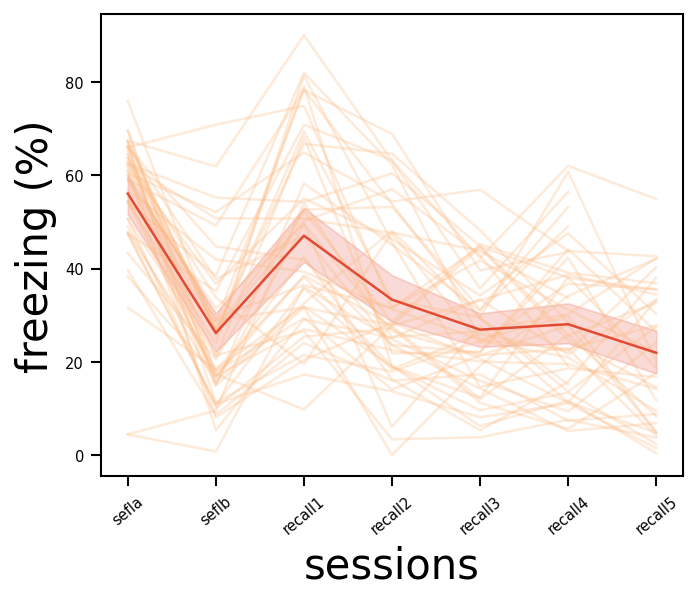

In [ ]:
f, ax = plt.subplots(figsize=(5,4),dpi=150)
g = sns.lineplot(data=filtered_freezing[filtered_freezing['condition']=='sefl'],
                 x='day', y='freezing', estimator=None, alpha=.3,units='cohort_id',
                 ax=ax, color='#fdbb84')
g = sns.lineplot(data=filtered_freezing[filtered_freezing['condition']=='sefl'],
                 x='day', y='freezing',
                 ax=ax, color='#e34a33')
ax.set_ylabel('freezing (%)',fontsize=20)
ax.set_xlabel('sessions', fontsize=20)
plt.xticks(rotation=40)

# plt.savefig(join(save_dir, 'sefl_freezing.png'),
#           transparent=True, dpi=300)
# plt.legend(fontsize=20)